# amLDS: application to mixtures and changes in stimulus intensity

This notebook shows the ability of amLDS decoding to generalize in response to changes in the properties of the stimulus (Note: run the "amLDS_example" notebook to familiarize yourself with amLDS parameter learning and inference). In section A, we test the decoding performance when linearly interpolating between two stimulus conditions. In section B, we explore the generalization in performance when decreasing the concentration/intensity of the stimulus.

## Import relevant modules and amLDS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
%load_ext autoreload
%autoreload 2
from funs.amLDS_engine import amLDS as amLDSm
from funs.amLDS_utils  import *

# Section A: mixtures

In this section, we will only look at two stimuli and mixtures between them (feel free to tweak the different variables and test other settings). 

## Define amLDS parameters and hyperparameters

In [3]:
nStim   = 2; nSbj = 1
sbjIDs  = ['sbj'+str(i)  for i in range(nSbj)]  
stimIDs = ['stim'+str(i) for i in range(nStim)]

zdim = 3                                     # same for all subjects and stimuli
xdim = {key: 40 for key in sbjIDs}           # subject specific ; could be different for different subjects
timepoints = 41                              # number of time steps ; it could vary on a trial by trial basis
trialN = 20                                  # number of trials per stimulus condition and subject ; could vary

In [4]:
np.random.seed(10)
# simulate latent parameters (stimulus specific) 
true_A_  = {key: A_init(zdim)  for key in stimIDs}
true_Q_  = {key: Q_init(zdim)  for key in stimIDs}
true_Q0_ = {key: Q_init(zdim)  for key in stimIDs}
true_x0_ = {key: x0_init(zdim) for key in stimIDs}
true_b_  = bs_init3D(stimIDs, angles=20)

# simulate observation parameters (subject specific)
refC     = C_init(xdim[sbjIDs[0]], zdim)
true_C_  = {key: C_inits(refC)     for key in sbjIDs}
true_R_  = {key: R_init(xdim[key]) for key in sbjIDs}

# force last two class conditions to have the same dynamic transitions
true_A_[stimIDs[-2]]  = np.copy(true_A_[stimIDs[-1]])
true_Q_[stimIDs[-2]]  = np.copy(true_Q_[stimIDs[-1]])
true_Q0_[stimIDs[-2]] = np.copy(true_Q0_[stimIDs[-1]])
true_x0_[stimIDs[-2]] = np.copy(true_x0_[stimIDs[-1]])

## Sample latent trajectories and observed measuraments

In [5]:
idxx = 33 ; idxx_val = 1033                                   # set seeds for training and test sets
amLDSsample = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs) # initialize model class

# sample from true latent parameters and structure observed data
XX = {} ; ZZ = {} ; XX_val = {}

for sbj in sbjIDs:
    CC = {} ; cc = {} ; CC_val = {}
    for stim in stimIDs:
        samples = []
        zamples = []
        for i in range(trialN):
            fooz, foox = amLDSsample.sample(A=true_A_[stim],   Q=true_Q_[stim], C=true_C_[sbj], R=true_R_[sbj], 
                                            x0=true_x0_[stim], b=true_b_[stim], timepoints= timepoints, seed=idxx)
            samples.append( foox )
            zamples.append( fooz )
            idxx +=1
        samples_val = []
        for i in range(int(10)): # number of validation trials
            samples_val.append(amLDSsample.sample(A=true_A_[stim], Q=true_Q_[stim],C=true_C_[sbj],R=true_R_[sbj], 
                                    x0=true_x0_[stim], b=true_b_[stim],timepoints= timepoints, seed=idxx_val)[1])
            idxx_val +=1
        CC[stim] = samples
        cc[stim] = zamples
        CC_val[stim] = samples_val
    XX[sbj] = CC
    ZZ[sbj] = cc
    XX_val[sbj] = CC_val

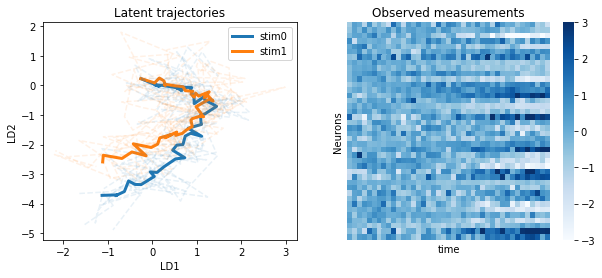

In [6]:
plot_LatentsObserveds(ZZ, sbjIDs[-1], stimIDs, XX, sbjIDs[-1], stimIDs[0])

This are example latent space dynamics for the different stimuli (left; solid lines are averages over trials and dashed lines five example trials); and an example trial for a given animal (right).

## amLDS parameter learning and decoding

In [7]:
amLDS = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs, timepoints=timepoints)  # initialize model class
amLDS.import_data(data=dict(XX))                                                # import data
amLDS.init_params(xdim=xdim[sbjIDs[0]], TL_FAinit=True, AQ_init=True)           # initialize parameters
amLDS.LDS_EM_TranferLearning();                                                 # EM parameter learning

Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM


## Sample mixtures and test decoding performance

The following cells sample new responses for different mixture ratios of the two original stimuli and tests the decoder generalization performance to those.

In [8]:
%%capture
mix_predict = []; zamples  = []; TEMP = []
sbjT  = sbjIDs[-1]; stimA = stimIDs[-2]; stimB = stimIDs[-1]
nTrmix = 20
ratios = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
for i in ratios:
    idxx  = 700
    samples  = []
    ratA = i; ratB = 1-i
    
    for jj in range(nTrmix):
        fooz, foox = amLDSsample.sample(A = true_A_[stimA]*ratA +true_A_[stimB]*ratB,   
                                        Q = true_Q_[stimA]*ratA +true_Q_[stimB]*ratB, 
                                        C = true_C_[sbjT], R=true_R_[sbjT], 
                                        x0= true_x0_[stimA]*ratA+true_x0_[stimB]*ratB, 
                                        b = true_b_[stimA]*ratA +true_b_[stimB]*ratB, 
                                        timepoints= timepoints, seed=idxx)
        samples.append(foox)
        idxx+=1
        if i == .5:
            zamples.append(fooz)

    XXab = dict({sbjIDs[-1]: {stimA: samples}})
    
    tempPr = amLDS.probability_decoding(XXab, sbjIDs=[sbjIDs[-1]])[0][sbjIDs[-1]]
    tempPr = tempPr[~np.isnan(tempPr).any(axis=1)]
    TEMP.append(tempPr)
    mix_predict.append(np.mean(np.argmax(tempPr, axis=1)))

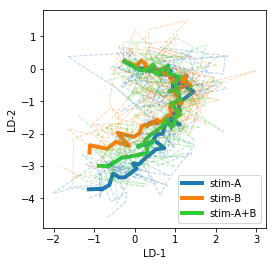

In [9]:
plot_mixtures(ZZ, stimA, stimB, sbjIDs[-1], zamples, nTrmix)

Average (solid lines) and example latents (dash lines) for the two original stimuli (A and B) and the 50-50 mixture between them.

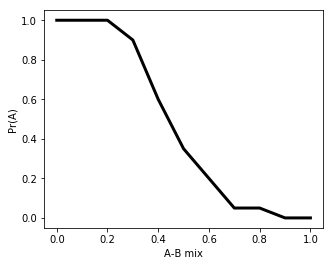

In [10]:
plt.figure(facecolor='w', figsize=(5,4))
plt.plot(ratios, np.array(mix_predict), '-', c='k', lw=3)
plt.ylabel('Pr(A)'); plt.xlabel('A-B mix');

Average decoding performance for the different mixtures of A and B. In the case of pure A (on the left) the decoder perfectly identifies the responses as A, but as the stimulus morphs into B, the decoder smoothly transitions between the two stimulus labels.

In [26]:
# fig, ax = plt.subplots(1, len(TEMP), facecolor='w', figsize=(20, 8))
# for m in range(len(TEMP)):
#     sns.heatmap(TEMP[m], cmap='binary', ax=ax[m], cbar=False);
#     ax[m].set_title(str(ratios[m]*100)+'-'+str(100-ratios[m]*100))
# ax[0].set_ylabel('trials')
# ax[0].set_xlabel('stim');

# Section B: concentration

In this section, we will test the generazation of the amLDS decoder to changes in concentration. We will mimic changes in concentration by decreasing the magnitude of the latent dynamics (parameter **b**).

## Define amLDS parameters and hyperparameters

In [11]:
nStim   = 10; nSbj = 5
sbjIDs  = ['sbj'+str(i)  for i in range(nSbj)]  
stimIDs = ['stim'+str(i) for i in range(nStim)]

zdim = 3                                     # same for all subjects and stimuli
xdim = {key: 40 for key in sbjIDs}           # subject specific ; could be different for different subjects
timepoints = 41                              # number of time steps ; it could vary on a trial by trial basis
trialN = 10                                  # number of trials per stimulus condition and subject ; could vary

In [12]:
np.random.seed(21) #7
# simulate true latent (stimulus specific) parameters
true_A_  = {key: A_init(zdim)  for key in stimIDs}
true_Q_  = {key: Q_init(zdim)  for key in stimIDs}
true_Q0_ = {key: Q_init(zdim)  for key in stimIDs}
true_x0_ = {key: x0_init(zdim) for key in stimIDs}
# true_b_  = bs_init(stimIDs)
true_b_  = bs_init3D(stimIDs, angles=170)

# simulate true observation (subject specific) parameters
refC = C_init(xdim[sbjIDs[0]], zdim)
true_C_  = {key: C_inits(refC)     for key in sbjIDs}
true_R_  = {key: R_init(xdim[key]) for key in sbjIDs}

## Sample latent trajectories and observed measuraments

In [13]:
trialSou = 30     # number of trials per stimulus condition and subject ; could vary
# initialize model class
amLDSsample = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs)
# sample from true latent parameters and structure observed data
XX = {}
idxx = 33
for sbj in sbjIDs:
    CC = {}
    for stim in stimIDs:
        samples = []
        for i in range(trialSou):
            samples.append(amLDSsample.sample(A=true_A_[stim], Q=true_Q_[stim], C=true_C_[sbj], R=true_R_[sbj], 
                                         x0=true_x0_[stim], b=true_b_[stim], timepoints= timepoints,seed=idxx)[1])
            idxx +=1
        CC[stim] = samples
    XX[sbj] = CC

## Sample latent trajectories at different concentrations

In [14]:
trialVal = 20   # number of trials for testing
# sample from true latent parameters and structure observed data
idxx_val = 1033
XX_valss = []
paramsss = [[1.1, 1.0, 1.0] , [.9,.8,.8], [.7,.6,.6], [.5,.4,.4], [.3,.2,.2]]
for par in paramsss:
    conc_b  = bs_init3D(stimIDs, angles=170, mu1=par[0],mu2=par[1],mu3=par[2])
    XX_val = {}
    for sbj in sbjIDs:
        CC_val = {}
        for stim in stimIDs:
            samples_val = []
            for i in range(int(trialVal)):
                samples_val.append(amLDSsample.sample(A=true_A_[stim], Q=true_Q_[stim], C=true_C_[sbj], 
                                                      R=true_R_[sbj],  x0=true_x0_[stim],b=conc_b[stim],
                                                      timepoints=timepoints,seed=idxx_val)[1]) 
                idxx_val +=1
            CC_val[stim] = samples_val
        XX_val[sbj] = CC_val
    XX_valss.append(XX_val)

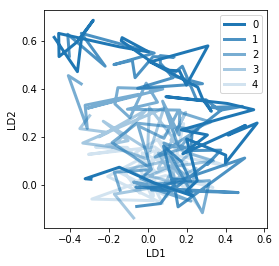

In [19]:
concZ = np.array([np.mean(XX_valss[i]['sbj0']['stim0'],axis=0) for i in range(len(XX_valss))])

plt.figure(facecolor='w', figsize=(4,4))
for i in range(concZ.shape[0]):
    plt.plot(concZ[i, :, 0], concZ[i, :, 1], c='#1f77b4', alpha=1-(i/5),lw=3)
plt.legend(range(5)); plt.xlabel('LD1'); plt.ylabel('LD2');

Example average latent trajectories for an example stimulus at different concentrations.

## amLDS parameter learning

In [21]:
TL_CN = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs, timepoints=timepoints)# initialize model class
TL_CN.import_data(data=XX)                                                    # import data
TL_CN.init_params(xdim=xdim[sbjIDs[0]], TL_FAinit=True ,AQ_init=True)         # initialize parameters
TL_CN.LDS_EM_TranferLearning();                                               # EM parameter learning

Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM


## amLDS decoding across concentrations

In [22]:
AccCN = [TL_CN.probability_decoding(XX_test)[2] for XX_test in XX_valss]     # decode in test set

Decoding stimulus class
Decoding stimulus class
Decoding stimulus class
Decoding stimulus class
Decoding stimulus class


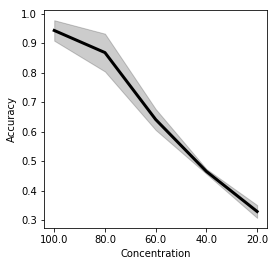

In [41]:
plot_concentrationPerformance(paramsss, AccCN, sbjIDs)

The classification performance decreases gradually as one decreases concentration, while still allowing for generalization across a wide range of concentrations.